<a href="https://colab.research.google.com/github/ilkersigirci/ML-with-Colab/blob/master/myTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import pprint
import tensorflow as tf
tf.reset_default_graph()
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')
#os.chdir("/content/drive/My Drive/Colab Notebooks")
os.chdir("/content")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
#!kaggle datasets list
!kaggle competitions download -c titanic -p "/content/drive/My Drive/Colab Notebooks/Dataset/titanic"
!ls

In [0]:
#not working with zip contains more than one file
data2 = pd.read_csv('/titanic.zip', compression='zip', header=0, sep=',', quotechar='"')

In [0]:
from zipfile import ZipFile
zip_file = ZipFile('titanic.zip')
fields = ['PassengerId','Name'] 
data = pd.read_csv(zip_file.open('test.csv'), usecols=fields)
data.head()

In [0]:
fields = ['PassengerId','Name'] 
data = pd.read_csv("Dataset/titanic/test.csv", usecols=fields)
data.head()

In [0]:
#rock = 1 / paper = 2 / scissors = 3
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import backend as K
from keras import callbacks
from sklearn.model_selection import train_test_split
import numpy as np

#dataset = np.loadtxt("Dataset/moves.csv")
dataset = pd.read_csv("Dataset/moves.csv")
dataset = dataset.to_numpy()
X = dataset[:,0:18]
Y = dataset[:,18]

Y=to_categorical(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

model = Sequential()

model.add(Dense(64, input_dim=18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1000, batch_size=150, validation_data=(x_test, y_test))

scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

model.save('model.h5')

In [0]:
#!mkdir mydata
os.chdir("/content/mydata")

In [0]:
!kaggle competitions download -c dogs-vs-cats -p "/content/mydata/dogsCats"

In [0]:
#!unzip -q "Dataset/dogsCats/mytest.zip" -d "Dataset/dogsCats"

from zipfile import ZipFile
zip_file = ZipFile("dogsCats/test1.zip", 'r')
zip_file.extractall("dogsCats/")
zip_file.close()

zip_file = ZipFile("dogsCats/train.zip", 'r')
zip_file.extractall("dogsCats/")
zip_file.close()

#!rm -rf dogsCats/test1

In [0]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

TRAIN_DIR = "dogsCats/train"
TEST_DIR = "dogsCats/test1"
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, 'SizeMatters2') # just so we remember which saved model is which, sizes must match

In [0]:
def label_img(img):
    word_label = img.split('.')[-3]
    if   word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]
    
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save("dogsCats/train_data.npy", training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save("dogsCats/test_data.npy", testing_data)
    return testing_data

In [54]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load("dogsCats/train_data.npy")

100%|██████████| 25000/25000 [00:21<00:00, 1138.53it/s]


In [0]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [0]:
train = train_data[:-500]
test = train_data[-500:]

In [0]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [58]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 10.99942 | time: 4.219s
| Adam | epoch: 003 | loss: 10.99942 - acc: 0.5223 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.30262 | time: 5.232s
| Adam | epoch: 003 | loss: 11.30262 - acc: 0.5091 | val_loss: 11.32872 - val_acc: 0.5080 -- iter: 24500/24500
--


In [59]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.45824 | time: 4.378s
| Adam | epoch: 003 | loss: 0.45824 - acc: 0.7831 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.45210 | time: 5.391s
| Adam | epoch: 003 | loss: 0.45210 - acc: 0.7939 | val_loss: 0.47493 - val_acc: 0.7860 -- iter: 24500/24500
--


In [0]:
model.save(MODEL_NAME)

In [63]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('C:/Users/H/Desktop/KaggleDogsvsCats/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 3829  | total loss: 0.27186 | time: 4.283s
| Adam | epoch: 010 | loss: 0.27186 - acc: 0.8818 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.26755 | time: 5.294s
| Adam | epoch: 010 | loss: 0.26755 - acc: 0.8811 | val_loss: 0.52095 - val_acc: 0.7940 -- iter: 24500/24500
--


100%|██████████| 12500/12500 [00:11<00:00, 1118.06it/s]


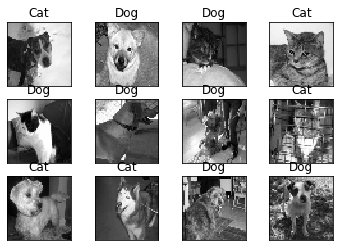

In [68]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load("dogsCats/test_data.npy")

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()